In [ ]:
from PIL import Image
import torch.nn as nn
import os
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
#All images follow this format Abstract_image_155


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device.type)

# Number of workers for dataloader
workers = 2

# Batch size during training
bs = 10

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = 24

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.99



###############
dataset = datasets.ImageFolder(root='G:/My Drive/Colab Notebooks/animals/',
#dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/animals/',
                               transform=transforms.Compose([
                                   transforms.Grayscale(num_output_channels=1), # Add this line
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,), (0.5,))
                               ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs,
                                         shuffle=True, num_workers=workers)
#################################


#not used
img_size = 200

print('test')
def noise(bs, nz):

    #Generate random Gaussian noise.

    return Variable(torch.randn(bs, nz, 1, 1))

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is noise size
            #switched from using ReLU to LeakyReLu
            nn.ConvTranspose2d( 100, ngf * 8, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d( ngf * 2, ngf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d( ngf * 2, nc, 3, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(1, ndf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(ndf , ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf *2 , ndf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 4, 1, 3, 1, 0, bias=False),
            nn.AdaptiveAvgPool2d(1),

            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

class GAN:
    def __init__(self, discriminator, generator, batch_size=1):
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.g_losses = []
        self.d_losses = []
        # Define binary cross entropy loss
        self.loss = nn.BCELoss()

        # Define separate optimizers for discriminator and generator
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=0.0018)
        self.g_optimizer = torch.optim.Adam(self.generator.parameters(), lr=0.0002)

    def train(self, num_epochs, dataloader, resume=False, checkpoint_path='G:/My Drive/Colab Notebooks/animals/checkpointWLL.pth'):
      # Training Loop for each epoch
      start_epoch = 0
      if resume:
        if os.path.isfile(checkpoint_path):
          print(f"=> loading checkpoint '{checkpoint_path}'")
          checkpoint = torch.load(checkpoint_path)
          start_epoch = checkpoint['epoch']
          self.generator.load_state_dict(checkpoint['generator_state_dict'])
          self.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
          self.g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
          self.d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
          print(f"=> loaded checkpoint '{checkpoint_path}' (epoch {checkpoint['epoch']})")
        else:
            print(f"=> no checkpoint found at '{checkpoint_path}'")

      for epoch in range(start_epoch, num_epochs):
        print ('Going')

        if epoch % 1 == 0:
          print('Generating Samples...')
          # Generate images from noise, using the generator network.
          count = 6
          for i in range(count):

            sample_vectors = noise(bs,100)
            samples = self.generator(sample_vectors)


            save_image(samples, f'G:/My Drive/Colab Notebooks/dandies/new_dandies/odludL_{epoch}_{i}.png', normalize=True)
            #save_image(samples, f'/content/drive/MyDrive/Colab Notebooks/dandies/new_dandies/Odlud_{epoch}_{i}.png', normalize=True)

            print ('Saved')
            # Batch Loop for each set of images and labels
          for n, (images, _) in enumerate(dataloader):


                real_images = Variable(images)
                #Switched from 1 to using .9 as the target
                real_labels = Variable(torch.full((bs,), 1.0))





                # Train Discriminator on real images
                self.d_optimizer.zero_grad()
                real_outputs = self.discriminator(real_images)
                real_outputs = real_outputs.squeeze()

                d_loss_real = self.loss(real_outputs, real_labels)
                d_loss_real.backward()

                # Prepare fake images and fake labels
                noise_vectors = noise(self.batch_size, nz)
                fake_images = self.generator(noise_vectors)
                fake_labels = Variable(torch.zeros(self.batch_size, 1)).view(-1)

                # Train Discriminator on real images
                self.d_optimizer.zero_grad()
                real_outputs = self.discriminator(real_images).view(-1).squeeze()
                real_outputs = real_outputs.squeeze()

                d_loss_real = self.loss(real_outputs, real_labels)
                d_loss_real.backward()

                # Prepare fake images and fake labels
                noise_vectors = noise(self.batch_size, nz)
                fake_images = self.generator(noise_vectors)
                fake_labels = Variable(torch.zeros(self.batch_size, 1)).view(-1)

                # Train Discriminator on fake images
                fake_outputs = self.discriminator(fake_images.detach()).view(-1)
                d_loss_fake = self.loss(fake_outputs, fake_labels)
                d_loss_fake.backward()

                # Update Discriminator weights
                self.d_optimizer.step()
                #self.d_losses.append(d_loss_real+d_loss_fake.item())

                # Train Generator to fool the Discriminator
                self.g_optimizer.zero_grad()
                noise_vectors = noise(self.batch_size, nz)
                fake_images = self.generator(noise_vectors)
                outputs = self.discriminator(fake_images).view(-1)

                # We train the generator to generate images that the discriminator will think are real
                g_loss = self.loss(outputs, Variable(torch.ones(self.batch_size)).view(-1))
                g_loss.backward()

                # Update Generator weights
                self.g_optimizer.step()
                self.g_losses.append(g_loss.item())

                if (n+1) % 1 == 0:
                    print(f'Epoch {epoch+1}/{num_epochs}, Step {n+1}, d_loss: {d_loss_real+d_loss_fake}, g_loss: {g_loss}')
                    torch.save({
                    'epoch': epoch,
                    'generator_state_dict': gan.generator.state_dict(),
                    'discriminator_state_dict': gan.discriminator.state_dict(),
                    'g_optimizer_state_dict': gan.g_optimizer.state_dict(),
                    'd_optimizer_state_dict': gan.d_optimizer.state_dict(),
                    'g_loss': g_loss,
                    'd_loss': d_loss_fake
                    }, 'checkpointWLL.pth')


generator = Generator()
discriminator = Discriminator()

gan = GAN(discriminator, generator)
gan.train(2000, dataloader, resume=False)

cpu
test
Going
Generating Samples...
Saved
Saved
Saved
Saved
Saved
Saved
Epoch 1/2000, Step 1, d_loss: 1.401515245437622, g_loss: 1.6915977001190186
Epoch 1/2000, Step 2, d_loss: 1.8128535747528076, g_loss: 1.145408272743225
Epoch 1/2000, Step 3, d_loss: 1.438502550125122, g_loss: 0.6117903590202332
Epoch 1/2000, Step 4, d_loss: 1.301833152770996, g_loss: 0.4910530149936676
Epoch 1/2000, Step 5, d_loss: 1.3385894298553467, g_loss: 0.5866345763206482
Epoch 1/2000, Step 6, d_loss: 1.216804027557373, g_loss: 0.7269443869590759
Epoch 1/2000, Step 7, d_loss: 1.1115347146987915, g_loss: 0.9349708557128906
Epoch 1/2000, Step 8, d_loss: 1.005630612373352, g_loss: 1.122554063796997
Epoch 1/2000, Step 9, d_loss: 0.9789180755615234, g_loss: 1.240742564201355
Epoch 1/2000, Step 10, d_loss: 0.9566237330436707, g_loss: 1.2992559671401978
Epoch 1/2000, Step 11, d_loss: 0.887370228767395, g_loss: 1.281833529472351
Epoch 1/2000, Step 12, d_loss: 0.7726877331733704, g_loss: 1.2602052688598633
Epoch 1/20

In [ ]:
pip install py

In [ ]:
import torch
torch.cuda.is_available()

False

NameError: ignored

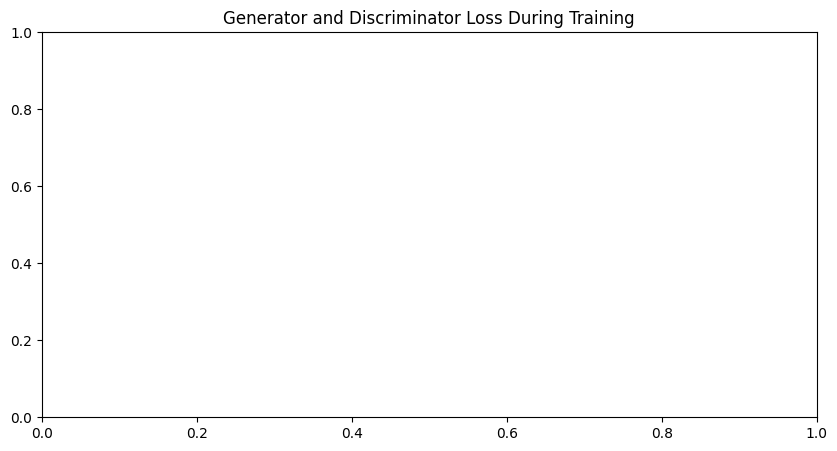

In [ ]:

#Visualize the generator and discriminator losses over epochs
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
sns.lineplot(data=gan.g_losses, label="G")
sns.lineplot(data=gan.d_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()